In [1]:
import pandas as pd
import numpy as np
import sys, os
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import statsmodels.formula.api as smf
from sklearn.model_selection import KFold
import statsmodels.api as sm
pd.set_option('display.max_columns', 50)
import matplotlib.cm as cm


# Import Data and Split

In [2]:
training_data_cleaned = pd.read_pickle("./Full_data.pkl")     ## Load in the cleaned data
A_1611 = training_data_cleaned['ID'] == 'A-1611'
training_data_cleaned = training_data_cleaned[~ A_1611]

In [3]:
A_1619 = training_data_cleaned['ID'] == 'A-1619'
A_1620 = training_data_cleaned['ID'] == 'A-1620'
A_1637 = training_data_cleaned['ID'] == 'A-1637'
IDs = {'A-1619' : A_1619, 'A-1620' : A_1620, 'A-1637' : A_1637}


In [4]:
for id_ in IDs:
    training_data_cleaned.loc[IDs[id_], 'kWh'] = training_data_cleaned[IDs[id_]].kWh/np.mean(training_data_cleaned[IDs[id_]].kWh)

In [5]:
training_data_cleaned = training_data_cleaned.drop(columns = ['timeStamp_y'])
training_data_cleaned.columns = training_data_cleaned.columns.str.replace(' ', '')
training_data_cleaned = training_data_cleaned.dropna()

In [6]:
training_data_cleaned = training_data_cleaned.drop(columns=['id', 'Flag']) 
training_data_cleaned.kWh = training_data_cleaned.kWh  / np.mean(training_data_cleaned.kWh )

In [7]:
test_set = training_data_cleaned.loc[training_data_cleaned["Year"] == 2016]
training_set = training_data_cleaned.loc[training_data_cleaned["Year"] < 2016]

In [8]:
training_set.ID.unique()

array(['A-1619', 'A-1620', 'A-1637'], dtype=object)

In [9]:
def get_MSE(predictions, y):
    return np.mean((y-predictions)**2)

In [10]:
predictors = training_data_cleaned.columns
predictors = list(predictors)
predictors.remove('kWh')
predictors.remove('ID')
predictors.remove('Year')
predictors.remove('timeStamp_x')

predictors

['Month',
 'Day',
 'Hour',
 'Minute',
 'RelativeHumidity',
 'DewPoint',
 'SurfaceAlbedo',
 'PrecipitableWater',
 'Pressure',
 'GHI',
 'DHI',
 'DNI',
 'WindSpeed',
 'Temperature',
 'SolarZenithAngle',
 'ClearskyGHI',
 'ClearskyDNI',
 'ClearskyDHI',
 'lat',
 'lang',
 'CloudType_0',
 'CloudType_1',
 'CloudType_2',
 'CloudType_3',
 'CloudType_4',
 'CloudType_6',
 'CloudType_7',
 'CloudType_8',
 'CloudType_9',
 'CloudType_10']

# Data Exploration - Dataframes

In [11]:
training_data_cleaned.head()

,ID,kWh,timeStamp_x,Year,Month,Day,Hour,Minute,RelativeHumidity,DewPoint,SurfaceAlbedo,PrecipitableWater,Pressure,GHI,DHI,DNI,WindSpeed,Temperature,SolarZenithAngle,ClearskyGHI,ClearskyDNI,ClearskyDHI,lat,lang,CloudType_0,CloudType_1,CloudType_2,CloudType_3,CloudType_4,CloudType_6,CloudType_7,CloudType_8,CloudType_9,CloudType_10
data_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A-1619_2010-08-12 00:00:00,A-1619,0.008508,2010-08-12,2010,8,12,0,0,98.54,10,0.149,2.839,1020.0,0,0,0,2.0,13,127.57,0,0,0,37.354113,-121.955174,1,0,0,0,0,0,0,0,0,0
A-1619_2010-08-12 00:00:00,A-1619,0.008508,2010-08-12,2010,8,12,0,0,98.54,10,0.149,2.839,1020.0,0,0,0,2.0,13,127.57,0,0,0,37.354113,-121.955174,1,0,0,0,0,0,0,0,0,0
A-1619_2010-08-12 00:00:00,A-1619,0.008508,2010-08-12,2010,8,12,0,0,98.54,10,0.149,2.839,1020.0,0,0,0,2.0,13,127.57,0,0,0,37.354113,-121.955174,1,0,0,0,0,0,0,0,0,0
A-1619_2010-08-12 00:00:00,A-1619,0.008508,2010-08-12,2010,8,12,0,0,98.54,10,0.149,2.839,1020.0,0,0,0,2.0,13,127.57,0,0,0,37.354113,-121.955174,1,0,0,0,0,0,0,0,0,0
A-1619_2010-08-12 00:00:00,A-1619,0.008508,2010-08-12,2010,8,12,0,0,98.54,10,0.149,2.839,1020.0,0,0,0,2.0,13,127.57,0,0,0,37.354113,-121.955174,1,0,0,0,0,0,0,0,0,0


In [12]:
training_data_cleaned.corr()

,kWh,Year,Month,Day,Hour,Minute,RelativeHumidity,DewPoint,SurfaceAlbedo,PrecipitableWater,Pressure,GHI,DHI,DNI,WindSpeed,Temperature,SolarZenithAngle,ClearskyGHI,ClearskyDNI,ClearskyDHI,lat,lang,CloudType_0,CloudType_1,CloudType_2,CloudType_3,CloudType_4,CloudType_6,CloudType_7,CloudType_8,CloudType_9,CloudType_10
kWh,1.000000e+00,0.015203,-0.075422,-0.005028,0.031250,0.000151,-0.649448,-0.029416,0.219691,-0.005468,-0.037608,0.926967,0.676289,0.816562,0.372169,0.618420,-0.789882,0.913123,0.827260,0.805273,-4.566614e-13,1.018773e-14,0.173087,-0.093176,0.122708,-0.025934,-0.097309,-0.062496,-0.086955,-0.027083,-0.018310,-0.002297
Year,1.520271e-02,1.000000,-0.118758,-0.009724,0.000180,0.000007,-0.039360,0.092268,0.243110,0.038657,0.018178,0.030250,0.019488,0.027538,0.055513,0.104506,-0.025589,0.020664,0.013361,0.017711,-2.766977e-02,3.042485e-01,-0.065717,0.095317,0.029812,0.002326,0.013442,-0.003757,-0.110317,0.138161,0.019775,-0.009877
Month,-7.542154e-02,-0.118758,1.000000,0.013044,-0.000200,-0.000021,-0.147051,0.006342,-0.275174,0.105528,-0.059405,-0.040760,-0.082395,-0.003965,-0.018244,0.148041,0.065097,-0.057163,-0.028900,-0.078316,-2.540589e-02,1.622171e-02,0.073005,-0.005952,-0.013740,-0.006596,-0.048955,-0.013844,-0.019225,-0.048074,-0.011846,0.001466
Day,-5.027610e-03,-0.009724,0.013044,1.000000,-0.000118,0.000070,0.012672,0.009915,-0.031287,0.019526,0.000565,-0.001571,-0.009332,0.001768,0.016095,-0.005440,0.000757,-0.000849,0.001239,-0.006837,-2.074717e-03,1.457457e-03,0.010029,0.002148,0.004451,0.000353,0.000077,0.007136,-0.008124,-0.025368,-0.003560,0.002908
Hour,3.125024e-02,0.000180,-0.000200,-0.000118,1.000000,-0.000039,-0.175683,0.017451,-0.000070,-0.001447,-0.015745,0.044117,0.033586,0.054142,0.123231,0.169902,-0.074597,0.041710,0.049519,0.046310,-3.888599e-05,5.244348e-05,0.033059,-0.033501,0.014992,-0.009008,-0.028023,-0.000113,0.006907,-0.000597,0.000277,0.000444
Minute,1.514145e-04,0.000007,-0.000021,0.000070,-0.000039,1.000000,0.013269,-0.004675,0.000045,-0.000225,-0.002167,-0.000183,0.000640,-0.000031,-0.010912,-0.015418,-0.000024,-0.000007,0.000147,0.000504,5.011028e-05,-1.688201e-04,-0.000550,-0.000360,-0.001576,-0.002315,0.001929,0.000556,-0.000080,0.002390,0.000786,0.001447
RelativeHumidity,-6.494479e-01,-0.039360,-0.147051,0.012672,-0.175683,0.013269,1.000000,0.308627,-0.229289,0.119621,0.178917,-0.718550,-0.478717,-0.721406,-0.332217,-0.778124,0.640100,-0.683030,-0.681065,-0.604237,-1.621403e-01,-1.413030e-01,-0.264958,0.083355,-0.068981,0.034263,0.130641,0.094697,0.135833,0.085841,0.027953,0.004061
DewPoint,-2.941589e-02,0.092268,0.006342,0.009915,0.017451,-0.004675,0.308627,1.000000,0.299763,0.629370,-0.168579,-0.012391,0.068229,-0.078764,0.102156,0.283094,-0.082996,0.021047,-0.016684,0.055679,-1.020134e-01,-5.323812e-02,-0.047640,-0.056942,0.006817,0.094053,-0.028579,0.045145,0.024504,0.062666,0.012900,-0.003626
SurfaceAlbedo,2.196911e-01,0.243110,-0.275174,-0.031287,-0.000070,0.000045,-0.229289,0.299763,1.000000,0.131377,-0.338288,0.251124,0.167055,0.180063,0.294978,0.423971,-0.284190,0.231676,0.131330,0.215908,1.480880e-01,1.845215e-01,0.186994,-0.023018,0.009977,0.004065,-0.108584,-0.081558,-0.125412,-0.047587,-0.012279,-0.002974
PrecipitableWater,-5.467933e-03,0.038657,0.105528,0.019526,-0.001447,-0.000225,0.119621,0.629370,0.131377,1.000000,-0.140844,0.008117,0.130112,-0.087838,0.131023,0.283202,-0.091221,0.065772,0.018145,0.112836,-3.935442e-02,2.531665e-03,-0.222809,-0.047123,0.022677,0.086904,0.093788,0.129916,0.124297,0.101078,0.030306,-0.000722


In [13]:
training_data_cleaned["CloudType_10"]

data_id
A-1619_2010-08-12 00:00:00    0
A-1619_2010-08-12 00:00:00    0
A-1619_2010-08-12 00:00:00    0
A-1619_2010-08-12 00:00:00    0
A-1619_2010-08-12 00:00:00    0
                             ..
A-1637_2016-12-30 21:30:00    0
A-1637_2016-12-30 22:00:00    0
A-1637_2016-12-30 22:30:00    0
A-1637_2016-12-30 23:00:00    0
A-1637_2016-12-30 23:30:00    0
Name: CloudType_10, Length: 664785, dtype: uint8

In [14]:
a = training_data_cleaned.loc[training_data_cleaned["CloudType_10"] == 1]
a

,ID,kWh,timeStamp_x,Year,Month,Day,Hour,Minute,RelativeHumidity,DewPoint,SurfaceAlbedo,PrecipitableWater,Pressure,GHI,DHI,DNI,WindSpeed,Temperature,SolarZenithAngle,ClearskyGHI,ClearskyDNI,ClearskyDHI,lat,lang,CloudType_0,CloudType_1,CloudType_2,CloudType_3,CloudType_4,CloudType_6,CloudType_7,CloudType_8,CloudType_9,CloudType_10
data_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A-1619_2010-11-20 17:30:00,A-1619,0.008072,2010-11-20 17:30:00,2010,11,20,17,30,96.35,7,0.133,1.811,1010.0,0,0,0,5.1,10,97.44,0,0,0,37.354113,-121.955174,0,0,0,0,0,0,0,0,0,1
A-1619_2010-11-20 17:30:00,A-1619,0.008072,2010-11-20 17:30:00,2010,11,20,17,30,96.35,7,0.133,1.811,1010.0,0,0,0,5.1,10,97.44,0,0,0,37.354113,-121.955174,0,0,0,0,0,0,0,0,0,1
A-1619_2010-11-20 17:30:00,A-1619,0.008072,2010-11-20 17:30:00,2010,11,20,17,30,96.35,7,0.133,1.811,1010.0,0,0,0,5.1,10,97.44,0,0,0,37.354113,-121.955174,0,0,0,0,0,0,0,0,0,1
A-1619_2010-11-20 17:30:00,A-1619,0.008072,2010-11-20 17:30:00,2010,11,20,17,30,96.35,7,0.133,1.811,1010.0,0,0,0,5.1,10,97.44,0,0,0,37.354113,-121.955174,0,0,0,0,0,0,0,0,0,1
A-1619_2010-11-20 17:30:00,A-1619,0.008072,2010-11-20 17:30:00,2010,11,20,17,30,96.35,7,0.133,1.811,1010.0,0,0,0,5.1,10,97.44,0,0,0,37.354113,-121.955174,0,0,0,0,0,0,0,0,0,1
A-1619_2010-12-21 01:00:00,A-1619,0.008072,2010-12-21 01:00:00,2010,12,21,1,0,100.00,4,0.133,1.401,1010.0,0,0,0,1.6,6,161.85,0,0,0,37.354113,-121.955174,0,0,0,0,0,0,0,0,0,1
A-1619_2010-12-21 01:00:00,A-1619,0.008072,2010-12-21 01:00:00,2010,12,21,1,0,100.00,4,0.133,1.401,1010.0,0,0,0,1.6,6,161.85,0,0,0,37.354113,-121.955174,0,0,0,0,0,0,0,0,0,1
A-1619_2010-12-21 01:00:00,A-1619,0.008072,2010-12-21 01:00:00,2010,12,21,1,0,100.00,4,0.133,1.401,1010.0,0,0,0,1.6,6,161.85,0,0,0,37.354113,-121.955174,0,0,0,0,0,0,0,0,0,1
A-1619_2010-12-21 01:00:00,A-1619,0.008072,2010-12-21 01:00:00,2010,12,21,1,0,100.00,4,0.133,1.401,1010.0,0,0,0,1.6,6,161.85,0,0,0,37.354113,-121.955174,0,0,0,0,0,0,0,0,0,1


## Correlation Matrix

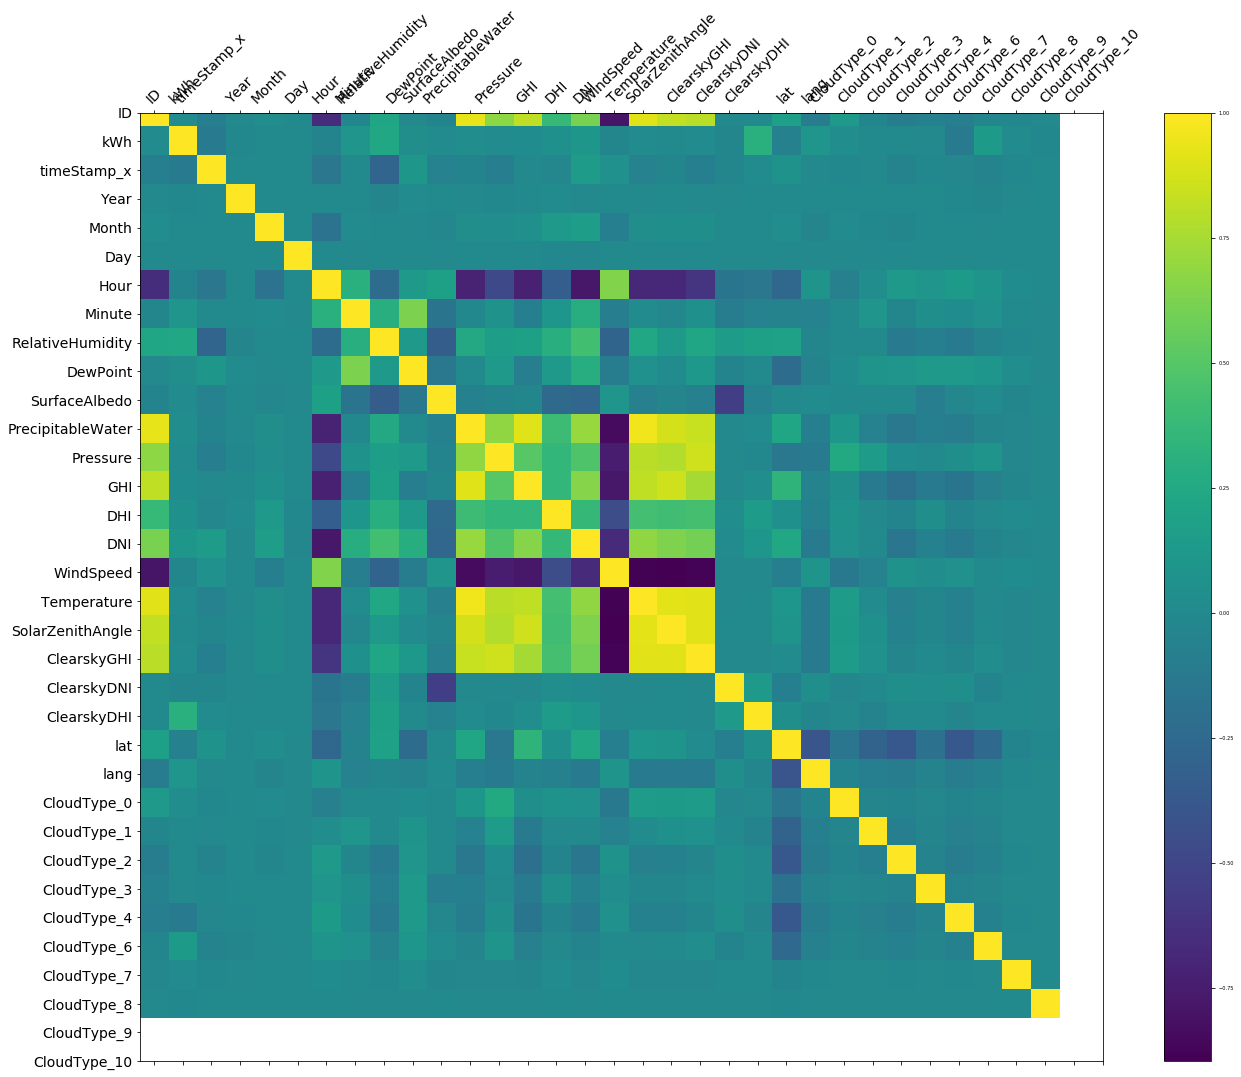

In [15]:
f = plt.figure(figsize=(22, 17))
plt.matshow(training_data_cleaned.corr(), fignum=f.number)
plt.xticks(range(training_data_cleaned.shape[1]), training_data_cleaned.columns, fontsize=14, rotation=45)
plt.yticks(range(training_data_cleaned.shape[1]), training_data_cleaned.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=5)

Note: Cloud Type 10 has all 0 values EXCEPT for 2 rows. This is why the correlation appears white above.

# Data Exploration - Energy to Time

In [16]:
hash_table = {key: i_str for i_str, key in enumerate(training_data_cleaned.ID)}
mpl_cmap = cm.get_cmap('viridis', lut=len(training_data_cleaned.ID))
training_data_cleaned['hash'] = training_data_cleaned.ID.apply(lambda x: hash_table[x])

In [17]:
def scatter_plot(feature, target):
    plt.figure(figsize=(16, 8))
    plt.scatter(
        training_data_cleaned[feature][::97],
        training_data_cleaned[target][::97],
        c=(mpl_cmap(training_data_cleaned.hash[::97]))
    )
    plt.xlabel("Predictor {}".format(feature))
    plt.ylabel("Solar Energy {}".format(target))
    plt.show()

In [18]:
training_data_cleaned['Year'].unique()

array([2010, 2011, 2012, 2013, 2014, 2015, 2016], dtype=int64)

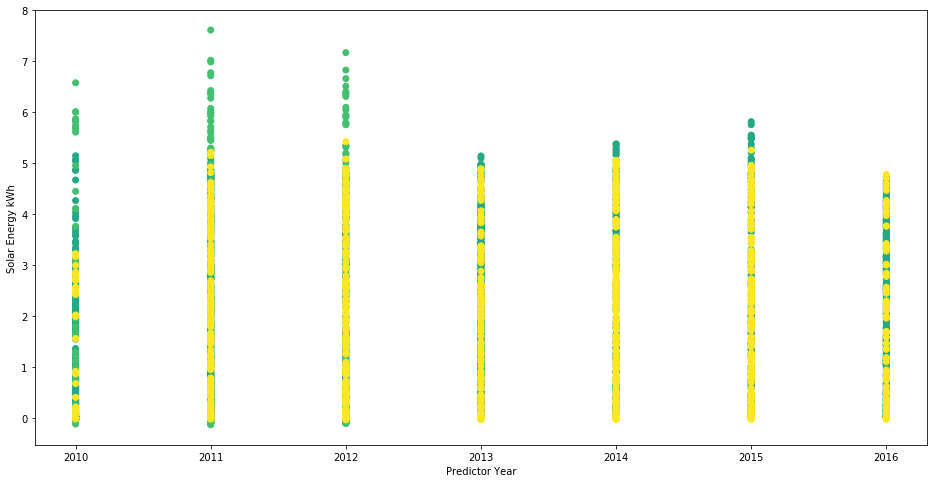

In [19]:
scatter_plot('Year','kWh')

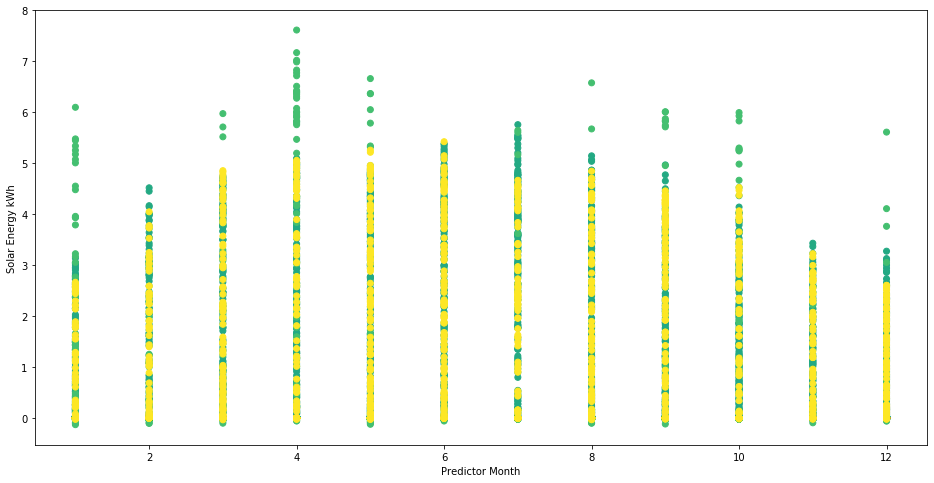

In [20]:
scatter_plot('Month','kWh')

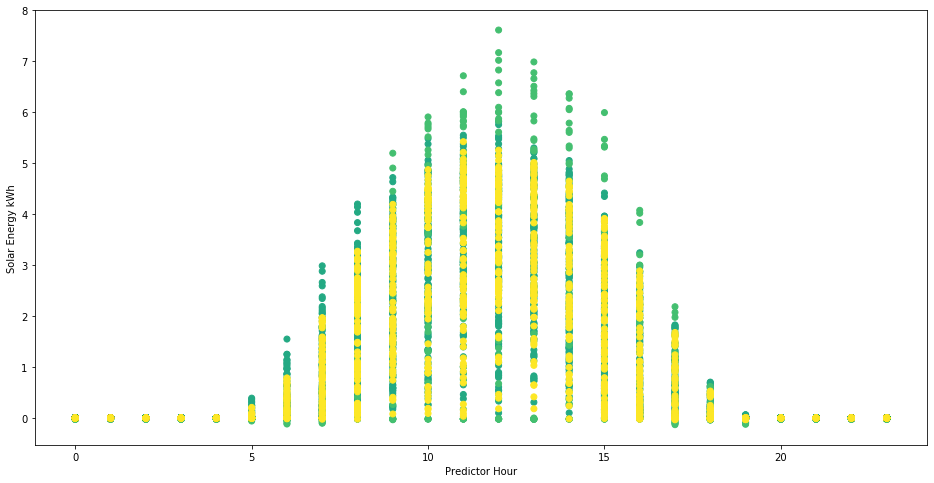

In [21]:
scatter_plot('Hour','kWh')

# Data Exploration - Energy to Weather

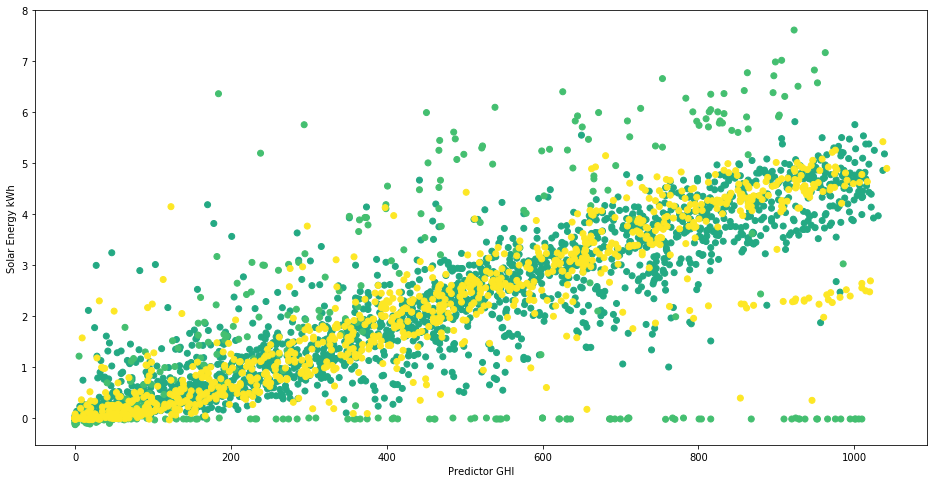

In [22]:
scatter_plot('GHI','kWh')

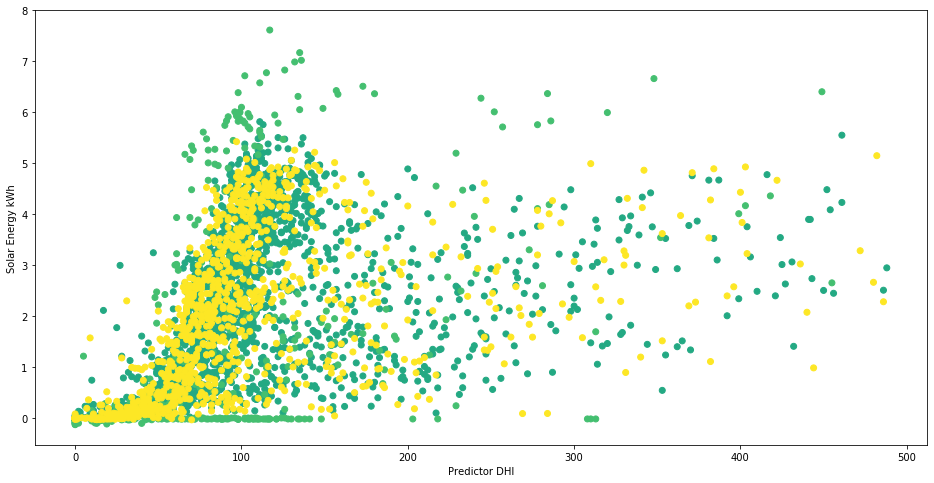

In [23]:
scatter_plot('DHI','kWh')

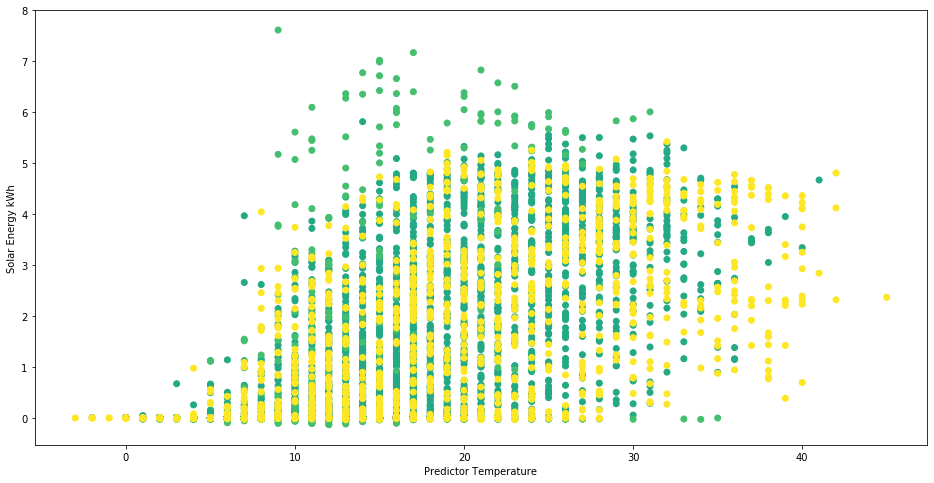

In [24]:
scatter_plot('Temperature','kWh')

# Model Selection - Forward Selection
Using k = 5 k-fold cross validation and forward selection, we find that the model with the following features:

GHI + Temperature + ClearskyGHI + DewPoint + RelativeHumidity + CloudType6 + CloudType2 + Pressure + CloudType3 + PrecipitableWater + WindSpeed + CloudType4 + CloudType0 + SolarZenithAngle + DNI + ClearskyDNI 

Although forward selection may not find the BEST combination of features, this method is heuristic and provides an efficient and practical model fit.

In [25]:
def get_k_folds(k, set) :
    set_random = set.sample(frac=1).reset_index(drop=True)
    return np.array_split(set_random, k) 

In [26]:
train_input = training_set[predictors]

In [27]:
training_set.head(2)

,ID,kWh,timeStamp_x,Year,Month,Day,Hour,Minute,RelativeHumidity,DewPoint,SurfaceAlbedo,PrecipitableWater,Pressure,GHI,DHI,DNI,WindSpeed,Temperature,SolarZenithAngle,ClearskyGHI,ClearskyDNI,ClearskyDHI,lat,lang,CloudType_0,CloudType_1,CloudType_2,CloudType_3,CloudType_4,CloudType_6,CloudType_7,CloudType_8,CloudType_9,CloudType_10
data_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A-1619_2010-08-12 00:00:00,A-1619,0.008508,2010-08-12,2010,8,12,0,0,98.54,10,0.149,2.839,1020.0,0,0,0,2.0,13,127.57,0,0,0,37.354113,-121.955174,1,0,0,0,0,0,0,0,0,0
A-1619_2010-08-12 00:00:00,A-1619,0.008508,2010-08-12,2010,8,12,0,0,98.54,10,0.149,2.839,1020.0,0,0,0,2.0,13,127.57,0,0,0,37.354113,-121.955174,1,0,0,0,0,0,0,0,0,0


In [37]:
predictors_temp = predictors


In [38]:
train_input.columns

Index(['Month', 'Day', 'Hour', 'Minute', 'RelativeHumidity', 'DewPoint',
       'SurfaceAlbedo', 'PrecipitableWater', 'Pressure', 'GHI', 'DHI', 'DNI',
       'WindSpeed', 'Temperature', 'SolarZenithAngle', 'ClearskyGHI',
       'ClearskyDNI', 'ClearskyDHI', 'lat', 'lang', 'CloudType_0',
       'CloudType_1', 'CloudType_2', 'CloudType_3', 'CloudType_4',
       'CloudType_6', 'CloudType_7', 'CloudType_8', 'CloudType_9',
       'CloudType_10'],
      dtype='object')

In [39]:
model = sm.OLS(training_set.kWh, sm.tools.add_constant(training_set[['GHI',
        'ClearskyGHI','Temperature']].values)).fit()



In [40]:
print(get_MSE(training_set.kWh, model.predict(sm.tools.add_constant(training_set[['GHI',
        'ClearskyGHI','Temperature']].values))))


    

0.3160514295748444


In [41]:
sm.tools.add_constant(test_set[['GHI','ClearskyGHI','Temperature']].values)

array([[1., 0., 0., 3.],
       [1., 0., 0., 3.],
       [1., 0., 0., 3.],
       ...,
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]])

In [42]:
print(get_MSE(test_set.kWh,model.predict(sm.tools.add_constant(test_set[['GHI','ClearskyGHI','Temperature']].values))))

0.21817243589805072


In [ ]:
train_error = {}
test_error = {}
used_predicters = []
for p in predictors:
    sub_data = train_input.drop(columns = used_predicters)
    mse = []; 
    for p in sub_data:
        curent_predictors = used_predicters + [p]
        model = sm.OLS(training_set.kWh, sm.tools.add_constant(training_set[curent_predictors].values)).fit()
        # Step 2: Find the predicted values using the current model
        yhat = model.predict(sm.tools.add_constant((training_set[curent_predictors].values)))
        # Step 3: Find the MSE for the current model and save
        mse.append(get_MSE(yhat, training_set.kWh))
    used_predicters += [sub_data.columns[mse.index(min(mse))]]
    
    k_data = training_set

    folds = get_k_folds(5, k_data)
    indices = np.arange(5)

    train_error_sub = []
    test_error_sub = []
    for i in range(0, len(folds)) :
        trainig_set_temp = pd.concat(folds[:i] + folds[i+1:])
        testing_set = folds[i]
        model = sm.OLS(trainig_set_temp.kWh, sm.tools.add_constant(trainig_set_temp[used_predicters].values)).fit()

        train_error_sub.append(get_MSE(trainig_set_temp.kWh, model.predict(sm.tools.add_constant(trainig_set_temp[used_predicters].values))))
        test_error_sub.append(get_MSE(testing_set.kWh,model.predict(sm.tools.add_constant(testing_set[used_predicters].values))))
    
    train_error[len(used_predicters)] = np.mean(train_error_sub)
    test_error[len(used_predicters)] = np.mean(test_error_sub)

In [ ]:
plt.figure(figsize=(6,5))

train_error_list = sorted(train_error.items()) # sorted by key, return a list of tuples
x, y_train = zip(*train_error_list)
test_error_list = sorted(test_error.items()) # sorted by key, return a list of tuples
x, y_test = zip(*test_error_list)
plt.plot(x,y_train, marker=".", label="train error")
plt.plot(x,y_test, marker=".", label="test error")

plt.legend()
plt.ylabel('MSE')
plt.xlabel('Feature number');
print('It seems like we should include ', y_test.index(min(y_test)))

In [ ]:
used_predicters

In [ ]:
test_set.columns

In [ ]:
sm.tools.add_constant(training_set[used_predicters[0:27]])


In [ ]:
training_set[used_predicters[0:28]].head(1)

In [ ]:
test_set[used_predicters[0:28]].head(1)

In [ ]:
sm.tools.add_constant(test_set[used_predicters[0:19]], prepend=True)

In [ ]:
model = sm.OLS(training_set.kWh, sm.tools.add_constant(training_set[used_predicters[0:27]])).fit()
y_hat_train = model.predict(sm.tools.add_constant(training_set[used_predicters[0:27]]))

In [ ]:
y_hat_test = model.predict(sm.tools.add_constant(test_set[used_predicters[0:27]], has_constant='add'))

In [ ]:
test_set = test_set.astype({"ID": str})

In [ ]:
hash_table = {key: i_str for i_str, key in enumerate(training_set.ID)}
mpl_cmap = cm.get_cmap('viridis', lut=len(training_set.ID))
training_set['hash'] = training_set.ID.apply(lambda x: hash_table[x])

In [ ]:
hash_table = {key: i_str for i_str, key in enumerate(test_set.ID)}
mpl_cmap = cm.get_cmap('viridis', lut=len(test_set.ID))


In [ ]:
training_set.ID.unique()

In [ ]:
test_set['hash'] = test_set.ID.apply(lambda x: hash_table[x])

In [ ]:
plt.figure(figsize=(16, 8))
plt.scatter(training_set["kWh"][::24*5+1],y_hat_train[::24*5+1], c=mpl_cmap(training_set.hash[::24*5+1]))
plt.xlabel("Y")
plt.ylabel("Y-hat")
plt.legend()
plt.title("Forward Selection - Y vs Y-hat train", size =20)
plt.show()

In [ ]:
plt.figure(figsize=(16, 8))
plt.scatter(test_set["kWh"][::97],y_hat_test[::97], c=mpl_cmap(test_set.hash[::97]))
plt.xlabel("Y")
plt.ylabel("Y-hat")
plt.legend()
plt.title("Forward Selection - Y vs Y-hat test", size =20)
plt.show()

In [ ]:
model.summary()



In [ ]:
test_set[test_set.ID == 'A-1611'].index

In [ ]:
plt.figure(figsize=(12,5))


#plt.plot(test_set.index[::97],y_hat[::97], label="prediction", c=mpl_cmap(test_set.hash[::97]))
#plt.plot(test_set.index[::97],test_set.kWh[::97], label="real", c=mpl_cmap(test_set.hash[::97]))
#plt.xlim('2011-12-26 01:00:00', '2012-09-26 01:00:00')
#plt.legend()
#plt.ylabel('behiverial response')
#plt.xlabel('time');

for id_name in IDs:  
    plt.figure(figsize=(16, 8))
    plt.scatter(
        training_set[training_set.ID == id_name]['timeStamp_x'],
        y_hat_train[training_set.ID == id_name], label = id_name + ' predicted')
    plt.scatter(
        training_set[training_set.ID == id_name]['timeStamp_x'],
        training_set[training_set.ID == id_name]['kWh'], label = id_name + ' real')
    plt.legend()
    plt.xlim('2012-08-01-00','2013-01-30-00')
    plt.show()

In [ ]:
MEE_forwerd = get_MSE(y_hat_test, test_set['kWh'])

In [ ]:
MEE_forwerd

In [ ]:
plt.figure(figsize=(12,5))


#plt.plot(test_set.index[::97],y_hat[::97], label="prediction", c=mpl_cmap(test_set.hash[::97]))
#plt.plot(test_set.index[::97],test_set.kWh[::97], label="real", c=mpl_cmap(test_set.hash[::97]))
#plt.xlim('2011-12-26 01:00:00', '2012-09-26 01:00:00')
#plt.legend()
#plt.ylabel('behiverial response')
#plt.xlabel('time');

for id_name in IDs:  
    plt.figure(figsize=(16, 8))
    plt.plot(
        test_set[test_set.ID == id_name]['timeStamp_x'],
        y_hat_test[test_set.ID == id_name], label = id_name + ' predicted')
    plt.plot(
        test_set[test_set.ID == id_name]['timeStamp_x'],
        test_set[test_set.ID == id_name]['kWh'], label = id_name + ' real')
    plt.legend()
   # plt.xlim('2016-01-01-00','2016-01-30-00')
    plt.show()



# Model Selection - Linear, Lasso, and Ridge

In [28]:
import statsmodels.api as sm


In [29]:
model = sm.OLS(training_set.kWh, sm.tools.add_constant(training_set[predictors].values))

trined_linear = model.fit()

get_MSE(training_set.kWh, trined_linear.predict(sm.tools.add_constant(training_set[predictors].values)))

0.3111966206432027

In [30]:
MSE_all = get_MSE(test_set.kWh, trined_linear.predict(sm.tools.add_constant(test_set[predictors].values)))
MSE_all

0.21259492884227732

In [31]:
alpha = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 40, 80, 160, 320, 640, 960, 1280,1920, 1560]


In [32]:
ridge_train_error = []
ridge_test_error = []
for a in alpha:
    ridge = model.fit_regularized(alpha=a, L1_wt=0)
    ridge_train_error.append(get_MSE(training_set.kWh, ridge.predict
                                     (sm.tools.add_constant(training_set[predictors].values))))
    ridge_test_error.append(get_MSE(test_set.kWh, ridge.predict
                                     (sm.tools.add_constant(test_set[predictors].values))))

In [33]:
ridge_test_error

[0.2125949288422707,
 0.2125949312429353,
 0.2125951693630472,
 0.21269688859036212,
 0.21236819993547187,
 0.20941363078605316,
 0.2092562660093941,
 0.20890779450984426,
 0.20839203368438328,
 0.20793193637320329,
 0.20781492532499604,
 0.20786258986261816,
 0.20824300613802668,
 0.20799081421940036]

In [34]:
min(ridge_test_error)

0.20781492532499604

In [35]:
alpha[ridge_test_error.index(min(ridge_test_error))]

960

In [44]:
ridge = model.fit_regularized(alpha=960, L1_wt=0)
ridge.params

array([-3.56683452e-07, -1.69753578e-04, -5.68999516e-05, -8.41320686e-05,
       -4.77716905e-06,  3.21614406e-04, -2.12842325e-04, -2.36385198e-07,
       -3.77416670e-05, -6.36581929e-05,  2.84049233e-03,  6.92979104e-05,
        2.26396162e-04, -2.16765533e-05, -4.09802907e-04,  2.68687566e-04,
        1.96366710e-03, -2.52670838e-04, -2.46561689e-04, -1.26834724e-05,
        3.84442943e-05, -1.88372489e-06, -1.95382910e-06,  3.03065951e-06,
        1.99742082e-06,  3.93723987e-06, -2.37842591e-06, -1.97653700e-06,
       -1.11312076e-06, -1.95506753e-08,  3.18470249e-09])

In [36]:
lasso_train_error = []
lasso_test_error = []
for a in alpha:
    print('testing ' , a)
    lasso = model.fit_regularized(alpha=a, L1_wt=1)
    lasso_train_error.append(get_MSE(training_set.kWh, lasso.predict
                                     (sm.tools.add_constant(training_set[predictors].values))))
    lasso_test_error.append(get_MSE(test_set.kWh, lasso.predict
                                     (sm.tools.add_constant(test_set[predictors].values))))

testing  1e-15


KeyboardInterrupt: 

In [37]:
min(lasso_test_error)

ValueError: min() arg is an empty sequence

In [ ]:
alpha[lasso_test_error.index(min(lasso_test_error))]

In [ ]:
lasso = model.fit_regularized(alpha=a, L1_wt=1)


In [ ]:
lasso_train_error.append(get_MSE(training_set.kWh, lasso.predict
         (sm.tools.add_constant(training_set[predictors].values))))
lasso_test_error.append(get_MSE(test_set.kWh, lasso.predict
         (sm.tools.add_constant(test_set[predictors].values))))